# RNN
En este notebook vamos a abarcar los siguientes temas:

- Predicción de los pasajeros de las aerolíneas internacionales (LSTM).
- LSTM para Regresión Usando el Método de la Ventana

Asimismo, se presentaran resultados de experimentos:
- Modificacion de la ventana del look back
- Modificacion de numero de neuronas en capas
- Modificacion del numero de capas

El objetivo sera encontrar aquellas modificaciones que nos permitan optimizar el modelo original, es decir, obtener un menor RSME. Para esto, realizaremos 3 tipos de experimentos:

1.  Dimensión de la ventana (look_back): Ajustar el tamaño de la ventana de entrada para analizar diferentes secuencias temporales.

2.  Número de neuronas por capa LSTM: Modificar la cantidad de neuronas en cada capa para evaluar el impacto en la capacidad de aprendizaje del modelo.

3.  Cantidad de capas LSTM: Experimentar con distintos números de capas para encontrar la configuración óptima.

Hemos realizado 3 experimentos por cada uno de estos tipos (9 en total), aunque solo en el codigo hemos presentado 3 de ellos (aunque hemos comentado aquellas partes del codigo que te llevarian a modificar los resultados a anteriores experimentos). Vale la pena resaltar que los experimentos seran independientes entre si, es decir, solo se realizara un cambio en algun parametro mientras que todos las demas decisiones permaneceran constantes. Esto, pues queremos evaluar que cambio marginal se daria en cada experimento.


## Montar Google Drive a Google Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importando packages necesarios

In [2]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

# semilla aleatoria para rerpoducibilidad
numpy.random.seed(7)

## Conjunto de datos


- Vamos a trabajar con el conjunto de datos disponible de forma gratuita en la página web de DataMarket.

- Los datos van de enero de 1949 a diciembre de 1960 o 12 años, con 144 observaciones.

<center>
<img width=500 src="https://unipython.com/wp-content/uploads/2018/09/Figure_1.png" img>
</center>

Para el modelo original, la primera columna que contiene el recuento de pasajeros de este mes (t) y la segunda columna que contiene el recuento de pasajeros del mes siguiente (t+1), que debe predecirse.

Sin embargo, uno de nuestros experimentos mantendra la primera columna (t) pero aumentara las tiempos que componene las siguiente columnas (t+1, t+2, etc)

### Cargando los datos

Para cargar el conjunto de datos usaremos a biblioteca Pandas. Para luego convertir los valores enteros en valores de coma flotante que son más adecuados para modelar con una red neuronal.



In [5]:
# cargamos el conjunto de datos
dataframe = read_csv('/content/drive/MyDrive/Colab Notebooks/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

Las Redes recurrentes son sensibles a la escala de los datos de entrada, especialmente cuando se utilizan las funciones de activación sigmoide (por defecto) o tanh. Puede ser una buena práctica reescalar los datos al rango de 0 a 1, también llamado normalización

In [6]:
# normalizacion de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### Entrenamiento y Pruebas

In [7]:
#dividimos datos en entreno y datos para el test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Creamos un función para crear un nuevo conjunto de datos tal y como se ha descrito anteriormente. La función toma dos argumentos, el conjunto de datos que es un array NumPy que queremos convertir en un conjunto de datos y el look_back, que es el número de pasos de tiempo previos que se deben utilizar como variables de entrada para predecir el siguiente período de tiempo.





In [8]:
# convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

### Experimento 1: Modificacion en la dimension de ventana del look_back

Para este experimento necesitaremos ajustar el tamaño de la ventana de entrada para analizar diferentes secuencias temporales. Es decir, modificaremos cuantas observaciones pasadas a nuestro valor actual (t) se utilizaran como caracteristicas para predecir a esta.

En este caso, elegimos utilizar una ventana mayor que incremento de 3 a 5 ya que permitira aumentar la cantidad de informacion que se puede usar. Esto nos hace suponer que el rendimiento de este modelo (2) sera mejor al que el del modelo original. Un caso de overfitting - y por lo tanto empeoramiento del modelo - seria raro aqui porque las observaciones ayudarian a entrenar al modelo ante mas posibles situaciones, pero no definen mas parametros que los del modelo actual.

Para esto, debemos entender que no cambiara la definicion del modelo, sino la composicion de las muestras de entrenamiento y prueba. Ahora ya no solo obtendremos 2 caracteristicas o periodos de tiempo, sino que seran 4. Dado ello, vamoa creat trainX_2 y testX_2 y las siguientes bases de datos de tal manera que cumplan con esto. Sin embargo, los siguiente modelos usaran los mismo trainX y trainY del modelo inicial porque lo que cambiara de ellos seran parametros del modelo, no los datos con los que se entrenara.

Cabe mencionar que se realizo otras variaciones del numero de dimensiones (2 y 4) pero que no se adiciono codigo adicional para presentar estos resultado aqui. Se mostraran los resultados del RMSE en la muestra de entrenamiento y prueba en los resultados finales.


In [9]:
#Remodelamos X=t y Y=t+1
## Train y test set originales
#Son los que usaremos para el modelo original, para la modificacion del numero de neuronas (experimento 2) y el numero de capas (experimento 3)
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX_shape = trainX.shape
print(f'Dimensiones de TrainX: {trainX_shape}')


## Train y test set para modificacion de look_back(experimento 1)
look_back_2 = 5
trainX_2, trainY_2 = create_dataset(train, look_back_2)
testX_2, testY_2 = create_dataset(test, look_back_2)

trainX_2_shape = trainX_2.shape
print(f'Dimensiones de TrainX_2: {trainX_2_shape}')



Dimensiones de TrainX: (92, 3)
Dimensiones de TrainX_2: (90, 5)


In [10]:
print(trainX[:5])

[[0.01544401 0.02702703 0.05405405]
 [0.02702703 0.05405405 0.04826255]
 [0.05405405 0.04826255 0.03281853]
 [0.04826255 0.03281853 0.05984557]
 [0.03281853 0.05984557 0.08494207]]


In [11]:
print(trainX_2[:5])

[[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853]
 [0.02702703 0.05405405 0.04826255 0.03281853 0.05984557]
 [0.05405405 0.04826255 0.03281853 0.05984557 0.08494207]
 [0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]
 [0.03281853 0.05984557 0.08494207 0.08494207 0.06177607]]


La red recorrentes espera que los datos de entrada (X) se proporcionen con una estructura de matriz específica en forma de: [muestras, pasos de tiempo, características]. Nuestros datos preparados están en la forma: [muestras, características] y estamos enmarcando el problema como un paso de tiempo para cada muestra. Haremos el cambio a la forma de entrada [muestras, pasos de tiempo, características] para ambos dos pares de bases de datos.

In [12]:

# cambiar la forma de la entrada para que sea[muestras, pasos de tiempo, características]

## para train y test set originales
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = numpy.reshape(testX, (testX.shape[0],testX.shape[1],1))

trainX_shape = trainX.shape
print(f'Dimensiones de TrainX: {trainX_shape}')


#para modificacion de look_back
trainX_2 = numpy.reshape(trainX_2, (trainX_2.shape[0], trainX_2.shape[1],1))
testX_2 = numpy.reshape(testX_2, (testX_2.shape[0],testX_2.shape[1],1))

trainX_2_shape = trainX_2.shape
print(f'Dimensiones de TrainX_2: {trainX_2_shape}')

Dimensiones de TrainX: (92, 3, 1)
Dimensiones de TrainX_2: (90, 5, 1)


In [13]:
print(trainX[:5])

[[[0.01544401]
  [0.02702703]
  [0.05405405]]

 [[0.02702703]
  [0.05405405]
  [0.04826255]]

 [[0.05405405]
  [0.04826255]
  [0.03281853]]

 [[0.04826255]
  [0.03281853]
  [0.05984557]]

 [[0.03281853]
  [0.05984557]
  [0.08494207]]]


In [14]:
print(trainX_2[:5])

[[[0.01544401]
  [0.02702703]
  [0.05405405]
  [0.04826255]
  [0.03281853]]

 [[0.02702703]
  [0.05405405]
  [0.04826255]
  [0.03281853]
  [0.05984557]]

 [[0.05405405]
  [0.04826255]
  [0.03281853]
  [0.05984557]
  [0.08494207]]

 [[0.04826255]
  [0.03281853]
  [0.05984557]
  [0.08494207]
  [0.08494207]]

 [[0.03281853]
  [0.05984557]
  [0.08494207]
  [0.08494207]
  [0.06177607]]]


## Modelo LSTM para Regresión


Código basado en [PREDICCIÓN CON SERIES TEMPORALES CON LSTM, REDES NEURONALES RECURRENTES](https://unipython.com/prediccion-con-series-temporales-con-lstm-redes-neuronales-recurrentes/)

### Modelo original
La red recurrente basiada en LSTM tiene una capa visible con 1 entrada, una capa oculta con 4 bloques LSTM o neuronas, otra capa oculta con 8 bloques LSTM o neuronas, una capa oculta con 4 bloques LSTM o neuronas, y una capa de salida que hace una sola predicción de valor.

### Experimento 2: modificacion del numero de neuronas en una capa.
La red recurrente basiada en LSTM tendra la misma estructura de capas que el modelo original, sin embargo, reducira el numero de neuronas de 8 a 2 en la segunda capa. Realizamos este cambio en direccion negativa ya que esperamos que esto ayude a reducir el overfitting que posiblemente puede estar pasando. Como en el anterior experimento, realizamos cambios adicionales (8 neuronas en la tercera capa y 4 en la segunda capa), y a pesar de mostrar el proceso aqui, mostraremos los resultados al final.

Tenemos una cantidad de observaciones y de variables o tiempos independientes no tan grande. Es decir, el tamanho de la muestra de entrenamiento no nos ayuda ampliamente puesto que el modelo no tendra mucha varianza. Mas aun, el modelo original que estamos usando tiene una cantidad considerable de parametros a estimar (757). Mas aun, las redes recurrentes no eliminan variables en su proceso de entrenamiento, sino que las mantienen y actualizan usando un estado oculto que contiene dependencias temporales. En este sentido, si bien puede llevar bien la informacion del modelo a lo largo de diferentes capas, no lo hace ajeno al overfitting, mas aun considerando que no tenemos capas que reduzcan la cantidad parametros, como pooling. La reduccion neuronas espera reducir los parametros y lo hace pues para este modelo ahora son 301.

### Experimento 3: modificacion del numero de capas.
La red recurrente basiada en LSTM tendra la misma estructura de capas que el modelo original, no obstante reducira el numero de capas eliminando la segunda y tercera capa del modelo. Al igual que el experimento anterior, el objetivo es reducir el overfitting, aunque esperamos que esta tecnica sea mejor en aquel trabajo. Al igual que los anteriores experimentos, los resultados de otros intentos (anhadir una capa de 8 neuronas y eliminar la tercera capa del modelo original) se presentaran al final.

Las justificaciones de este cambio son similares a las del anterior experimento: limitada cantidad de datos y una amplia cantidad de parametros a estimar sin reduccion de ellos en alguna parte del modelo. Sin embargo, para este modelo esperamos que este modelo obtengan un mejor desempenho que la modificacion anterior (y que el modelo original) ya que ahora no solo reducimos la cantidad de parametros a  133, sino tambien reduciendo las dependencias temporales que pueden estar causando overfitting al tener una cantidad de caracteristicas pequena (2).






Construyendo nuestra red recurente

In [15]:
# creacion de la red LSTM

#Modelo original
#Es el mismo modelo que usaremos para cuando hemos modificado el look back (experimento 1)
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back),return_sequences=True))
model.add(LSTM(8, input_shape=(look_back,1),return_sequences=True))
model.add(LSTM(4, input_shape=(look_back,1)))
model.add(Dense(1))

#Modelo con diferente numero de neuronas (experimento 2)
model_2 = Sequential()
model_2.add(LSTM(4, input_shape=(1, look_back),return_sequences=True))
model_2.add(LSTM(2, input_shape=(look_back,1),return_sequences=True))
model_2.add(LSTM(4, input_shape=(look_back,1)))
model_2.add(Dense(1))

#Modelo con diferente numero de capas (experimento 3)
model_3 = Sequential()
model_3.add(LSTM(4, input_shape=(1, look_back))) #,return_sequences=True
#model_3.add(LSTM(8, input_shape=(look_back,1))) #,return_sequences=True
#model_3.add(LSTM(8, input_shape=(look_back,1),return_sequences=True))
#model_3.add(LSTM(4, input_shape=(look_back,1)))
model_3.add(Dense(1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Visualizacion de la red LSTM

#### Modelo original

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 4)                │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 8)                │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 4)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 757 (2.96 KB)

 Trainable params: 757 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

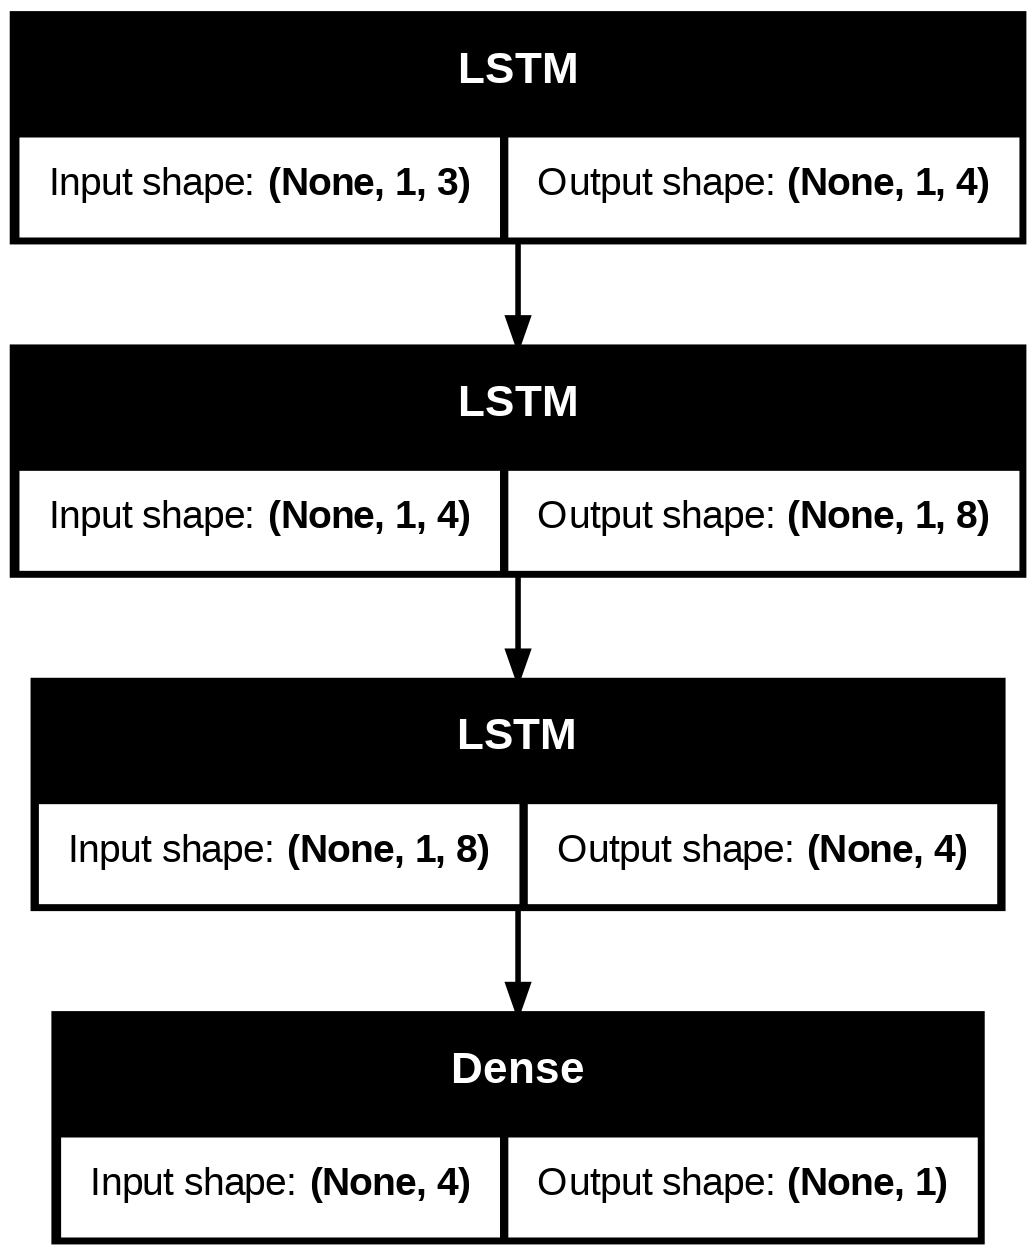

In [17]:
plot_model(model, to_file="model_lstm.png", show_shapes=True)

#### Modelo con modificacion de numero de neuronas (experimento 2)

In [18]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 1, 4)                │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1, 2)                │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 4)                   │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

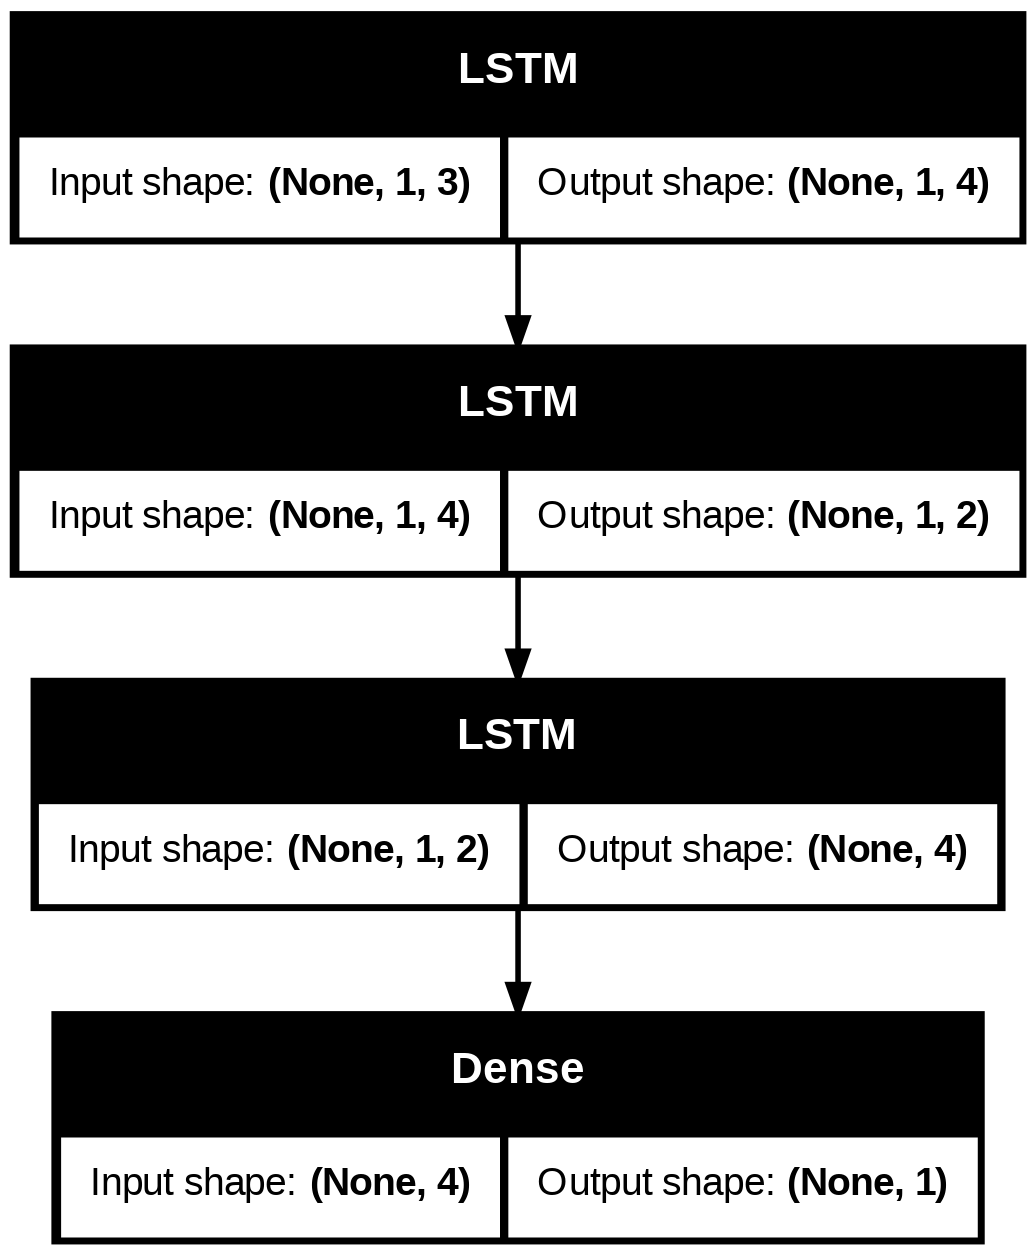

In [19]:
plot_model(model_2, to_file="model_2_lstm.png", show_shapes=True)

#### Modelo con modificacion de numero de capas (experimento 3)

In [20]:
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 4)                   │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133 (532.00 B)

 Trainable params: 133 (532.00 B)

 Non-trainable params: 0 (0.00 B)

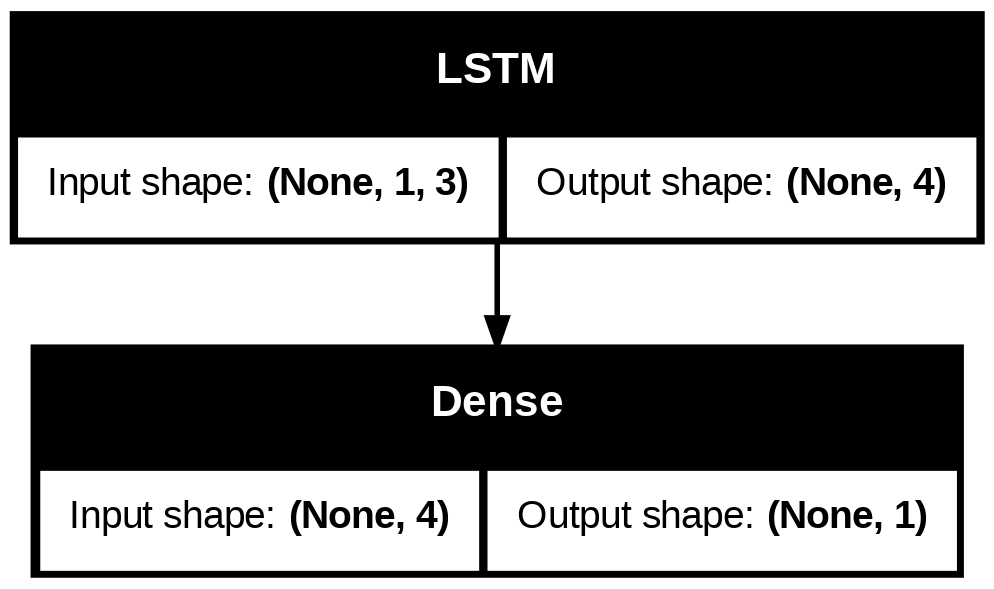

In [21]:
plot_model(model_3, to_file="model_3_lstm.png", show_shapes=True)

### Configuración de Entrenamiento

In [22]:
#Modelo original
model.compile(loss='mean_squared_error', optimizer='adam')
#Modelo con modificacion de numero de neuronas
model_2.compile(loss='mean_squared_error', optimizer='adam')
#Modelo con modificacion de numero de capas
model_3.compile(loss='mean_squared_error', optimizer='adam')

## Training

Entrenamos todos los modelos con sus respectivas muestras y por separado, manteniendo la cantidad epochs, batchsize y verbose igual para todos ellos. En general, no toma mas de 10 minutos correr los 4 modelos (otra de las razones para solo incluir aquellos modelo que optimizan los resultados en comparacion con el original).

In [23]:
#Modelo original
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0446
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0182
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0191
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0166
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0060
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070
Epoc

In [24]:
#Modelo para modificacion de look_back(experimento 1)
history_2 = model.fit(trainX_2, trainY_2, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0103
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0053
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033
Epoch 10/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030
Epoch 11/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034
Epoch 12/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027
Epoch 13/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025
Epoch 14/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031
Epoch 15/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoc

In [25]:
### Modelo con modificacion de numero de neuronas (experimento 2)
history_3 = model_2.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0343
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0189
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0191
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0195
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0189
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0205
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0201
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0145
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0186
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0256
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0176
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172
Epoc

In [26]:
### Modelo con modificacion de numero de capas (experimento 3)
history_4 = model_3.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0660
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105
Epoc

## Evaluando el Modelo

In [27]:
# Hacemos las predicciones

#Modelo original
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#Modelo con modificacion de look_back(experimento 1):
trainPredict_2 = model.predict(trainX_2)
testPredict_2 = model.predict(testX_2)

#Modelo con modificacion de numero de neuronas (experimento 2):
trainPredict_3 = model_2.predict(trainX)
testPredict_3 = model_2.predict(testX)

#Modelo con modificacion de numero de capas (experimento 3):
trainPredict_4 = model_3.predict(trainX)
testPredict_4 = model_3.predict(testX)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [28]:
# Invertimos las predicciones

#Modelo original
trainPredict = scaler.inverse_transform(trainPredict)
trainY_1 = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_1 = scaler.inverse_transform([testY])

#Modelo para modificacion de look_back (experimento 1):
trainPredict_2 = scaler.inverse_transform(trainPredict_2)
trainY_2 = scaler.inverse_transform([trainY_2])
testPredict_2 = scaler.inverse_transform(testPredict_2)
testY_2 = scaler.inverse_transform([testY_2])


In [30]:

#Modelo con modificacion de numero de neuronas (experimento 2)
trainPredict_3 = scaler.inverse_transform(trainPredict_3)
trainY_3 = scaler.inverse_transform([trainY])
testPredict_3 = scaler.inverse_transform(testPredict_3)
testY_3 = scaler.inverse_transform([testY])

#Modelo con modificacion de numero de capas (experimento 3)
trainPredict_4 = scaler.inverse_transform(trainPredict_4)
trainY_4 = scaler.inverse_transform([trainY])
testPredict_4 = scaler.inverse_transform(testPredict_4)
testY_4 = scaler.inverse_transform([testY])

## Visualizando las predicciones

In [31]:
# Calculamos el error rms

#Para modelo original
print('En el modelo original encontramos:')
trainScore = math.sqrt(mean_squared_error(trainY_1[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_1[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore))

#Modelo para modificacion de look_back (experimento 1):
print('En el modelo con modificacion de look_back:')
trainScore_2 = math.sqrt(mean_squared_error(trainY_2[0], trainPredict_2[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_2))
testScore_2 = math.sqrt(mean_squared_error(testY_2[0], testPredict_2[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore_2))

#Modelo con modificacion de numero de neuronas (experimento 2):
print('En el modelo con modificacion de numero de neuronas:')
trainScore_3 = math.sqrt(mean_squared_error(trainY_3[0], trainPredict_3[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_3))
testScore_3 = math.sqrt(mean_squared_error(testY_3[0], testPredict_3[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore_3))

#Modelo con modificacion de numero de capas (experimento 3):
print('En el modelo con modificacion de numero de capas:')
trainScore_4 = math.sqrt(mean_squared_error(trainY_4[0], trainPredict_4[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_4))
testScore_4 = math.sqrt(mean_squared_error(testY_4[0], testPredict_4[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore_4))

En el modelo original encontramos:
Resultado del entrenamiento: 42.16 RMSE
Resultado del test: 97.94 RMSE
En el modelo con modificacion de look_back:
Resultado del entrenamiento: 21.33 RMSE
Resultado del test: 69.22 RMSE
En el modelo con modificacion de numero de neuronas:
Resultado del entrenamiento: 32.18 RMSE
Resultado del test: 103.71 RMSE
En el modelo con modificacion de numero de capas:
Resultado del entrenamiento: 23.63 RMSE
Resultado del test: 57.38 RMSE


# Resultados:


De esta manera, podemos notar que el Modelo 2 (modificacion con aumento en la ventana del look back) y el Modelo 4 )modificacion con reduccion de 3 a 1 capa) han logrado reducir el RSME tanto en la muestra de entrenamiento como en la de prueba. Como esperabamos, ambos modelos - debido obtener mas informacion gracias a mayor look_back y que generan menor overfitting dado la reduccion de capas - predicen mejor el modelo fuera de la muestra.

Sin embargo, el modelo 3, aquel que reduce la cantidad de neuronas que se uso en una capa, mejora el resultado en la muestra de entrenamiento, pero no en la muestra de prueba, aunque por poco lo logra. Esto nos indica que reducir la cantidad de neuronas no sera tan eficiente reduciendo el overfitting como eliminar una capa. Sin embargo, es sorprendente que haya empeorado el resultado en la muestra de prueba, mas aun, parece que empeoro el overfitting puesto que este el modelo con menor RSME en la muestra de entrenamiento.


| **Métrica**         | **Modelo Original** | **Modelo 2** | **Modelo 3** | **Modelo 4** |
|---------------------|---------------------|--------------|--------------|--------------|
| **RSME**            |                     |              |              |              |
| - Entrenamiento     | 42.16               | 21.33        | 32.18        | 23.63        |
| - Test              | 97.94               | 69.22        | 102.71       | 57.38        |

In [32]:
# Predicciones del entrenamiento de cambio para plotear

## Modelo original:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

## Modelo con modificacion de look_back(experimento 1):
trainPredictPlot_2 = numpy.empty_like(dataset)
trainPredictPlot_2[:, :] = numpy.nan
trainPredictPlot_2[look_back_2:len(trainPredict_2)+look_back_2, :] = trainPredict_2

## Modelo con modificacion de numero de neuronas (experimento 2):
trainPredictPlot_3 = numpy.empty_like(dataset)
trainPredictPlot_3[:, :] = numpy.nan
trainPredictPlot_3[look_back:len(trainPredict_3)+look_back, :] = trainPredict_3

## Modelo con modificacion de numero de capas (experimento 3):
trainPredictPlot_4 = numpy.empty_like(dataset)
trainPredictPlot_4[:, :] = numpy.nan
trainPredictPlot_4[look_back:len(trainPredict_4)+look_back, :] = trainPredict_4

In [33]:

# Predicciones del test de cambio para plotear

##Modelo original:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

##Modelo modificacion de look_back(experimento 1):
testPredictPlot_2 = numpy.empty_like(dataset)
testPredictPlot_2[:, :] = numpy.nan
testPredictPlot_2[len(trainPredict_2)+(look_back_2*2)+1:len(dataset)-1, :] = testPredict_2

## Modelo con modificacion de numero de neuronas (experimento 2):
testPredictPlot_3 = numpy.empty_like(dataset)
testPredictPlot_3[:, :] = numpy.nan
testPredictPlot_3[len(trainPredict_3)+(look_back*2)+1:len(dataset)-1, :] = testPredict_3

## Modelo con modificacion de numero de capas (experimento 3):
testPredictPlot_4 = numpy.empty_like(dataset)
testPredictPlot_4[:, :] = numpy.nan
testPredictPlot_4[len(trainPredict_4)+(look_back*2)+1:len(dataset)-1, :] = testPredict_4


## Plot baseline and predictions




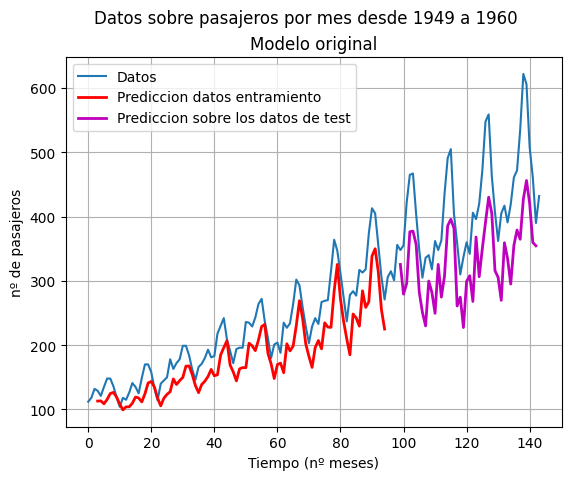

In [34]:
## Modelo original
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.suptitle("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 12)
plt.title("Modelo original")
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

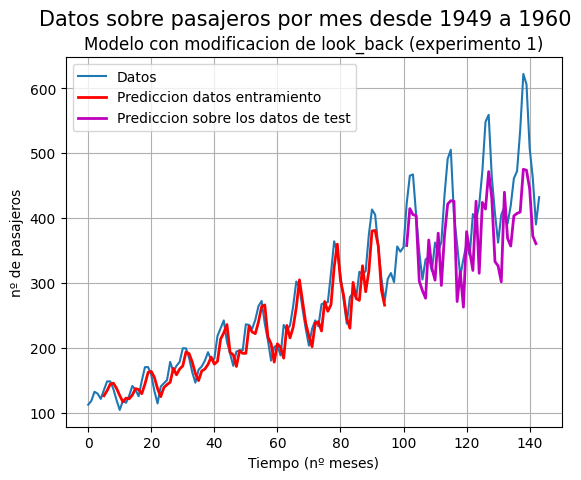

In [35]:
## Modelo modificacion de look_back(experimento 1)
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot_2,'r', linewidth = 2)
plt.plot(testPredictPlot_2,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.suptitle("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.title("Modelo con modificacion de look_back (experimento 1)")
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

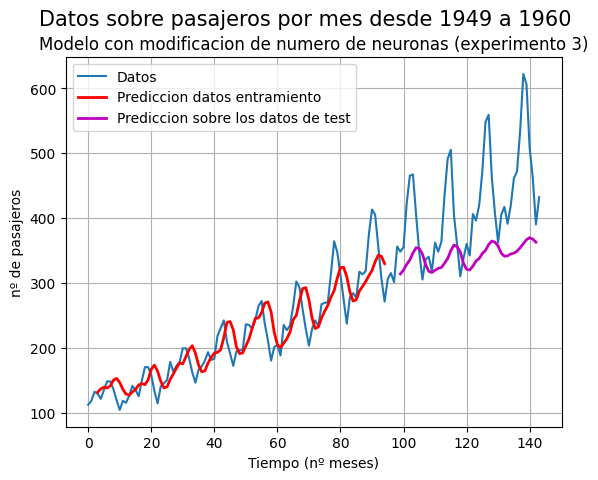

In [36]:
## Modelo modificacion de numero de neuronas (experimento 3)
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot_3,'r', linewidth = 2)
plt.plot(testPredictPlot_3,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.suptitle("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.title("Modelo con modificacion de numero de neuronas (experimento 3)")
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

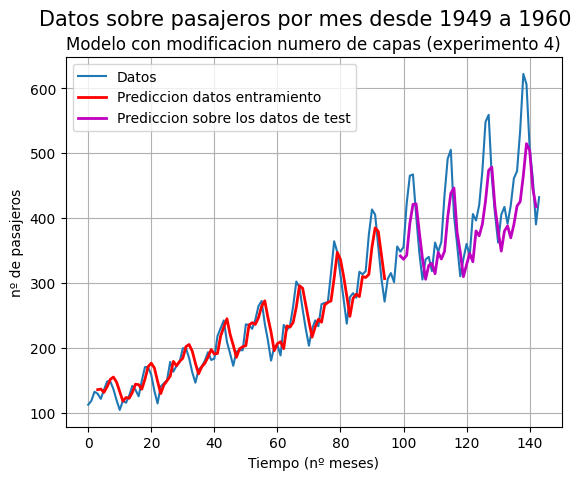

In [37]:
## Modelo modificacion de numero de capas (experimento 4)
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot_4,'r', linewidth = 2)
plt.plot(testPredictPlot_4,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.suptitle("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.title("Modelo con modificacion numero de capas (experimento 4)")
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

## Resultados incluyendo estimaciones no presentes en el codigo

| **Métrica**                                              | **RMSE Entrenamiento** | **RSME Prueba** |
|----------------------------------------------------------|------------------------|-----------------|
| **Modelo original**                                      | 42.16                  | 97.74           |
| **Modificación en la ventana del look back**             |                        |                 |
| - Modelo 2                                               | 21.33                  | 69.22           |
| - 4 como look back                                       | 20.26                  | 61.05           |
| - 2 como look back                                       | 20.56                  | 70.91           |
| **Modificación en el número de neuronas por capa**       |                        |                 |
| - Modelo 3                                               | 32.18                  | 102.71          |
| - Aumentamos las neuronas de 4 a 8 neuronas en la tercera capa | 24.14           | 91.92           |
| - Reducimos las neuronas de 8 a 4 en la segunda capa     | 31.80                  | 98.51           |
| **Modificación en capas**                                |                        |                 |
| - Modelo 4                                               | 23.63                  | 57.38           |
| - Aumentamos una cuarta capa con 8 neuronas              | 32.74                  | 107.85          |
| - Eliminamos la tercera capa con 4 neuronas              | 23.52                  | 67.73           |

Antes de explicar los resultados, vale la pena resaltar que cada experimento fue independiente del otro. Es decir, solo se cambio el parametro o medida que se menciona en la cada fila de la tabla manteniendose todas las otras variables iguales a las del modelo original.

Expandiendo los resultados a aquellos experimentos pasados encontramos los siguientes resultados que ponen en pedestal nuestros resultados anteriores. Primero, evaluando las modificaciones en la ventana en el look_back,  encontramos que si bien aumentar este valor mejora el resultado, 4 parece ser el valor optimo entre las opciones que hemos tratado pues reduce el RSME mas para la muestra de entrenamiento prueba que cualquier otro de los experimentos.
Sin embargo, esto aun esta a favor de neustra hipotesis: aumentar la ventana en el look back mejorara el rendimiento debido a que tendremos mas informacion para entrenar el modelo.

Con respecto a las modificaciones en el numero de neuronas, encontramos resultados interesantes, pues parece que un aumento de neuronas en la tercera capa fue aquella modificacion que nos hizo obtener un menor RSME para entrenamiento y prueba. Sin embargo, no muy lejos de estos valores se encuentran los demas de las otras modificaciones del numero de neuronas por cada que reducen este numero. Esto nos lleva a plantear que nuestra hipotesis era erronea: mayor cantidad de neuronas parece reducir el RSME, aunque muy pobremente en comparacion con otros tipos de modificaciones.

Finalmente, encontramos que la reduccion en la cantidad de capas del modelo mejora los resultados del RSME. Aqui parece ser que nuestras razones declaradas anteriormente tienen mas sentido. En otras palabras, que el overfitting se reduce drasticamente al tener que estimar menos parametros con una cantidad de observaciones pequenha.
